In [1]:
from gurobipy import *
import time
import pandas as pd
from scipy.spatial.distance import euclidean
import networkx as nx
import matplotlib.pyplot as plt
import folium
import numpy as np

In [2]:
path = 'customers.txt'
# read text file
with open(path, encoding='utf8') as f:
    lines = f.readlines()
    
rows = []
for line in lines:
    row = line.strip().split('\t')
    rows.append(row)
df = pd.DataFrame(rows, columns = rows[0])
df = df.drop(0)
df = df.set_index('CUST NO.')

first_row = df.iloc[0]
df = pd.concat([df, first_row.to_frame().transpose()], ignore_index=True)
df = df.astype({'X COORD.': 'float', 'Y COORD.': 'float', 'POPULATION NO.': 'int', 'SURVIVAL_PROBABILITY': 'float'})
df.head()

,X COORD.,Y COORD.,POPULATION NO.,SURVIVAL_PROBABILITY
0,0.0,0.0,0,1.00
1,0.0,1.0,4,0.86
2,0.0,2.0,3,1.24
3,0.0,3.0,2,2.56
4,0.0,4.0,0,0.00


In [3]:
Ndrones = 1 # Número de drones
k = Ndrones
n = len(df) - 2 # Número de clientes


N = range(1, len(df.index) - 1) # Índice de clientes {1, 2, ..., n}
V = range(len(df.index)) # Índice de clientes y depósito {0, 1, ..., n+1}
S = range(1,Ndrones + 1) # Índice de rutas inicales 





# Se crean los arcos del grafo
arcos = []
for i in V:
    for j in V:
        if i != j:
            if i != len(V) - 1 and j != 0:
                arcos.append(tuple((i,j)))
arcos.remove((0, len(df) - 1))




# Se calculan los costos (distancias)

t = {} # Tiempo en minutos
for arc in arcos:
    point1 = df.loc[arc[0], ['X COORD.', 'Y COORD.']].values
    point2 = df.loc[arc[1], ['X COORD.', 'Y COORD.']].values
    distance = euclidean(point1, point2)
    t[arc] = distance
# Parameter that accounts for the population of node j
l = {(i,j): df['POPULATION NO.'][j] for (i,j) in arcos}   

# Probability of vulnerability of node j
P_ij = {(i,j): df['SURVIVAL_PROBABILITY'][j] if j != len(df)-1 else 0 for (i,j) in arcos}
 
# Weights for each objective in the FO
#w1 = 1
#w2 = 6
w1 = 1
w2 = 6

# Cost of node j (by entering j independent of i)
c = {(i,j): w1 * l[i,j] + w2 * P_ij[i,j] for (i,j) in arcos}



T = 12 #max(t.values())*2+1 # Time limit

### Warm-Start using Greedy Best heuristic

Taken from A. Anastasiou, P. Kolios, C. Panayiotou and K. Papadaki, "Swarm Path Planning for the Deployment of Drones in Emergency Response Missions," 2020 International Conference on Unmanned Aircraft Systems (ICUAS), Athens, Greece, 2020, pp. 456-465, doi: 10.1109/ICUAS48674.2020.9213876.
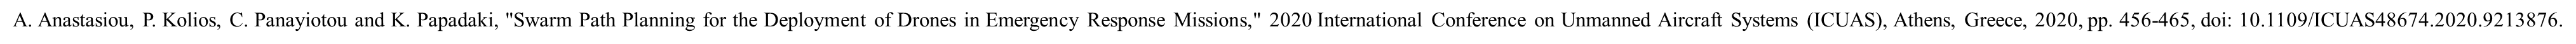
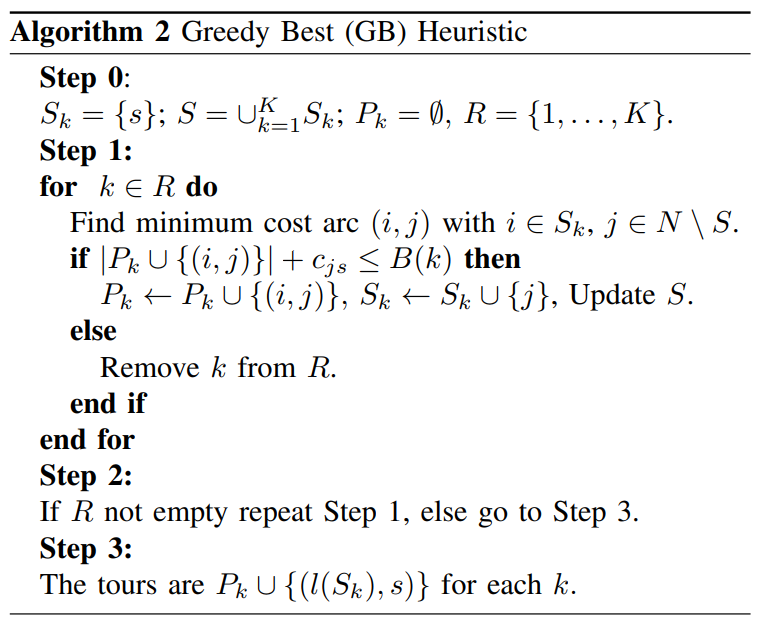

#### Function to find the minimum cost arc

In [4]:
def minimum_cost_arc(S_k, S):
    minimum = 10e6
    arc = 0
    for (i,j) in arcos:
        if i in S_k and j in N and j not in S:
            if t[i,j] < minimum:
                minimum = t[i,j]
                arc = tuple((i,j))
    return minimum, arc

In [5]:
S_k = {k: [0] for k in S} # Sets that will grow iteratively corresponding to each UAV to form the UAV's tour
S_heur = [0]
P_k = {k: [] for k in S} # Paths
R = [k for k in S]



while R:
    for k in R:

        cost, arc = minimum_cost_arc(S_k[k], S_heur)
        i_arc = arc[0]
        j_arc = arc[1]

        t_path = sum(t[i,j] for (i,j) in P_k[k])


        if t_path + t[0, j_arc] <= T:
            P_k[k].append(tuple(arc))
            S_k[k].append(j_arc)
            S_heur.append(j_arc)
            S_k[k].remove(i_arc) ###### LÍNEA QUE NO APARECE EN EL PSEUDO-CÓDIGO PERO ES ESENCIAL

        else:
            R.remove(k)
for k in S:
    last_node = P_k[k][-1][1]
    P_k[k].append(tuple((last_node, n+1)))

In [6]:
original_dict = P_k
new_dict = {}
for key, value in original_dict.items():
    new_value = []
    for arc in value:
        new_value.append([arc])
    new_dict[key] = new_value

Visualisation of the initial solution

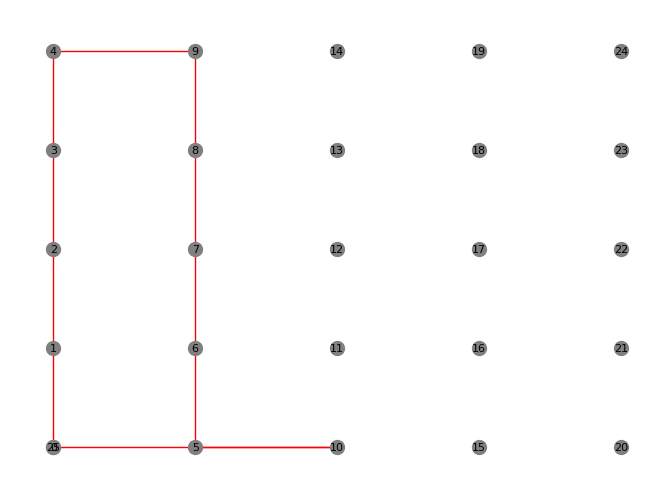

In [7]:
# assume your dataframe is called 'df'
coord_dict = {idx: (row['X COORD.'], row['Y COORD.']) for idx, row in df.iterrows()}

# assume coord_dict is the dictionary of node coordinates
# assume routes_dict is the dictionary of routes

# create an empty graph
G = nx.Graph()

# add nodes to the graph using the coordinates from coord_dict
for idx, coords in coord_dict.items():
    G.add_node(idx, pos=coords)

# add edges to the graph using the routes in routes_dict
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink'] # define a list of colors for the routes
for idx, (route_id, route) in enumerate(new_dict.items()):
    for edge in route:
        G.add_edge(edge[0][0], edge[0][1], color=colors[idx]) # add the edge color for each route

# draw the graph using the node positions and edge colors
pos = nx.get_node_attributes(G, 'pos')
edge_colors = [G[u][v]['color'] for u,v in G.edges()] # set the edge colors based on the color attribute of each edge
nx.draw(G, pos, node_size=100, node_color='grey', with_labels=True, font_size=8, edge_color=edge_colors)

# show the plot
plt.show()

In [8]:
import folium
from folium import plugins

# Define the latitude and longitude of the origin in Armero, Colombia
origin_latitude = 5.025
origin_longitude = -74.8865
 
# Define the scaling factor (adjust as per your needs)
scaling_factor = 0.0015  # Example: 0.0015 degree per unit

# Convert the Cartesian coordinates to latitude and longitude
converted_coordinates = []
for coord in pos.values():
    x, y = coord
    latitude = origin_latitude + (scaling_factor * y)
    longitude = origin_longitude + (scaling_factor * x)
    converted_coordinates.append([latitude, longitude])

node_coords = converted_coordinates

# Define the center of the map
center = [origin_latitude, origin_longitude]  # Coordinates 

# Create the map
m = folium.Map(location=center, zoom_start=15)

# Define a list of colors to use for each route
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Loop through each route in new_dict and plot it on the map
for i, route in new_dict.items():
    # Get the color for this route
    color = colors[i % len(colors)]
    
    # Create a list of coordinates for this route
    coordinates_list = []
    for arc in route:
        start_node = arc[0][0]
        end_node = arc[0][1]
        start_coord = node_coords[start_node]
        end_coord = node_coords[end_node]
        coordinates_list.append(start_coord)
        coordinates_list.append(end_coord)
    
    # Add the route to the map as a PolyLine
    folium.PolyLine(locations=coordinates_list, color=color).add_to(m)

# Create a list of node coordinates and corresponding probability values
node_coordinates = [node_coords[node] for node in range(len(node_coords))]
node_probabilities = [P_ij[arc] for arc in P_ij]  # Assuming P_ij is the dictionary of arc probabilities


heat_data = []
contador = 0
for coord in node_coordinates:
    if coord != center:
        heat_data.append([coord[0], coord[1], node_probabilities[contador]])
        contador += 1
    else: 
        heat_data.append([origin_latitude, origin_longitude,0])
heat_map = plugins.HeatMap(heat_data)

# Add the HeatMapWithTime layer to the map
heat_map.add_to(m)

# Display the map
m

Parameters setting based on warm-start

In [9]:
G = nx.DiGraph()
G.add_edges_from(arcos)

contador_s = 0
T_acum = 0



b_ijs = {(i,j,s): 0 for (i,j) in arcos for s in S }
for k in S:
    for (i,j) in P_k[k]:
        b_ijs[i,j,k] = 1
        

a_is = {(i,s): sum(b_ijs[i,j,s] for j in G.successors(i)) for i in G.nodes for s in S if i <= len(df)-2}

c_s = {s: sum(c[i,j] * b_ijs[i,j,s] for (i,j) in arcos) for s in S}

### Master problem

This problem is modelled as the knapsack problem which is proved to be NP-Hard

In [10]:
modelMP = Model('MasterProblem')

# Variables

theta = {s: modelMP.addVar(vtype = GRB.CONTINUOUS, obj = c_s[s], name = 'theta' + str(s)) for s in S}

# Constraints

Ctrs = []
for i in N:
    Ctrs.append(modelMP.addConstr(quicksum(a_is[i,s]*theta[s] for s in S) <= 1, name = str(i)))

Ctrs.append(modelMP.addConstr(quicksum(theta[s] for s in S) <= k))



# Maximise
modelMP.ModelSense = -1


# Model's parameters
modelMP.setParam("OutputFlag", 0) 
modelMP.setParam('Threads', 8)
modelMP.update()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-18


### Auxiliary problem

This problem is modelled as the longest-path problem with resource constraints

In [11]:
m = Model('AuxProblem')


# Variables

b = {(i,j): m.addVar(vtype = GRB.BINARY, name = 'b' + str(i)+str(j)) for (i,j) in arcos}

start_node = 0
end_node = n+1


# Constraints

# Exit origin node only once
m.addConstr(quicksum(b[start_node, j] for j in N) == 1)

# Enter destination node only once
m.addConstr(quicksum(b[i, end_node] for i in N) == 1)

# Flow constraints
for i in N:
    m.addConstr(quicksum(b[i,j] for j in G.successors(i)) - quicksum(b[j,i] for j in G.predecessors(i)) == 0)
    
    
    

### Chat GPT


# Add binary variable for each node to track whether it is visited in the path
z = {}
for i in G.nodes():
    z[i] = m.addVar(vtype=GRB.BINARY, name='z_{0}'.format(i))    
    
# Add MTZ constraints for each node (except start and end)
M = G.number_of_nodes() + 1
u = {}
for i in G.nodes():
    if i != start_node and i != end_node:
        u[i] = m.addVar(vtype=GRB.CONTINUOUS, name='u_{0}'.format(i))#

for i in G.nodes():
    if i != start_node and i != end_node:
        for j in G.nodes():
            if j != start_node and j != end_node and i != j:
                expr = u[i] - u[j] + M * b[i, j] <= M - 1 - M * (1 - z[j])
                m.addConstr(expr)

                
# Resource constraint (time)
m.addConstr(quicksum(t[i,j]*b[i,j] for (i,j) in arcos) <= T)



# Maximise
m.ModelSense = GRB.MINIMIZE


# Model's parameters
m.setParam("OutputFlag", 0) 
m.setParam('Threads', 8)

m.update()

### Column Generation method

In [12]:
init_time = time.time()
notOptimal = True


GAP = 0 # Optimality gap in decimal
time_limit = 1000 # time limit in minutes


contador = 0
new_columns = []
a_iC = 0
routes = {}
ruta = []
rutaa = []

while  notOptimal:
    
    # Linear relaxtion MP
    modelMP.optimize()
    
    
    # Dual variables
    duals = modelMP.getAttr('Pi', modelMP.getConstrs())
    OF = modelMP.objVal
    
    
    
    
    # Calculate auxiliary's problem cost using dual variables of the relaxed master problem
    c_q = {(i,j): -(c[i,j] - duals[i-1]) if i in N else c[i,j] for (i,j) in arcos}
    #print(c_q)
    #print('duals: ', duals)
    
    # Set gradient in the auxiliary problem
    m.setObjective(quicksum(c_q[i,j]*b[i,j] for (i,j) in arcos))
    
    
    # Sets stopping criteria
    m.setParam('MIPGap', GAP)
    m.setParam('TimeLimit', 60*time_limit)
    m.update()
    m.optimize()
    
    
    # Saves reduced cost of auxiliary problem
    reduced_cost = m.objVal + duals[-1]
    
    
    
    # Save last column
    a_i_old = a_iC

    # Calculates new column based on decision variable b_ij
    a_iC = {(i): sum(b[i,j].x for j in G.successors(i)) for i in N}
    a_iC = list(a_iC.values())
    a_iC.append(1)
    
    # Calculates new route cost based on decision variable b_ij
    new_cost = sum(c[i,j] * b[i,j].x for (i,j) in arcos)
    
    
    

    # Saves route for new column
    ruta = []
    rutaa = []
    for (i,j) in arcos:
        if b[i,j].x >= 0.5:
            ruta.append(tuple((i,j))) 
            rutaa.append([tuple((i,j))])
    
    
    
    # Checks for optimality criteria
    if reduced_cost >= 0:
        print('Column generation stops! with a reduced cost of:', reduced_cost)
        print('Best MP upper bound:', OF)
        notOptimal = False
    else:
        
        # Saves new column
        newCol = Column(a_iC, Ctrs)
        
        # Adds new variable based on new column 
        modelMP.addVar(vtype = GRB.CONTINUOUS, lb = 0, obj = new_cost, column = newCol)
        modelMP.update()  
        
        
        # Cut to prevent routes already added
        m.addConstr(quicksum(b[i,j] for (i,j) in ruta) <= len(ruta) - 1)
        m.update()        

  
        routes[contador+k+1] = rutaa
        c_s[contador+k+1] = new_cost
        
        
        # Saves columns added
        new_columns.append(a_iC)
        contador += 1
        
        #if contador % 10 == 0:
        print('colmumn:',a_iC)
        print('reduced cost:',reduced_cost)
        print('RMP OF:', OF)

        #if contador >= 5:
        #    break
      
            
# Set variables to binary in the master problem        
for v in modelMP.getVars():
    v.setAttr('vtype', GRB.BINARY)
    
# Solve original master problem
modelMP.optimize()
print('Integer MP OF:', modelMP.objVal)
tiempo = round(time.time()-init_time,4)
print('Computational time:', tiempo, 's')

colmumn: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1]
reduced cost: -112.46000000000001
RMP OF: 84.16000000000001
colmumn: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1]
reduced cost: -111.10000000000001
RMP OF: 114.46000000000001
colmumn: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1]
reduced cost: -21.879999999999995
RMP OF: 114.46000000000001
colmumn: [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1]
reduced cost: -26.780000000000015
RMP OF: 114.46000000000001
Column generation stops! with a reduced cost of: 2.6200000000000045
Best MP upper bound: 135.68
Integer MP OF: 135.68
Computational time: 63.7398 s


### Final routes chosen by the integer master problem

In [13]:
opt_routes = {}
for i in range(len(modelMP.x)):
    if modelMP.x[i] >= 0.5 and i <= k-1:
        opt_routes[i+1] = new_dict[i+1]
        print('Initial routes provided by Greedy Best heuristic selected by MP')
    elif modelMP.x[i] >= 0.5 and i > k-1:
        opt_routes[i+1] = routes[i+1]

In [14]:
def make_routes_contiguous(route_dict):
    new_route_dict = {}

    for route_id, segments in route_dict.items():
        # Flatten the segments into a single list
        flattened_segments = [segment[0] for segment in segments]

        # Create a dictionary to map each node to its corresponding segments
        node_segments = {}
        for segment in flattened_segments:
            start_node, end_node = segment
            if start_node not in node_segments:
                node_segments[start_node] = []
            if end_node not in node_segments:
                node_segments[end_node] = []
            node_segments[start_node].append(segment)
            node_segments[end_node].append(segment)

        # Reconstruct the route by traversing the nodes in sequence
        ordered_segments = []
        current_node = flattened_segments[0][0]
        while flattened_segments:
            next_segment = None
            for segment in node_segments[current_node]:
                if segment in flattened_segments:
                    next_segment = segment
                    break
            if next_segment is None:
                break
            ordered_segments.append([next_segment])
            flattened_segments.remove(next_segment)
            current_node = next_segment[1]

        # Add the ordered segments to the new route dictionary
        new_route_dict[route_id] = ordered_segments

    return new_route_dict
opt_routes = make_routes_contiguous(opt_routes)

### Visualisation of the solution in a grid 

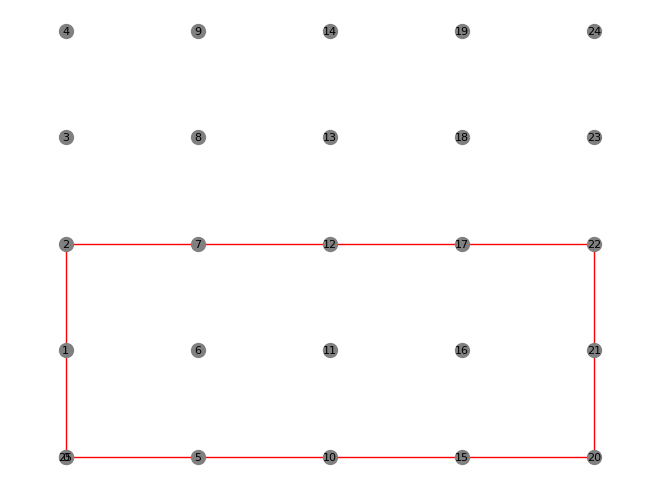

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# assume your dataframe is called 'df'
coord_dict = {idx: (row['X COORD.'], row['Y COORD.']) for idx, row in df.iterrows()}

# assume coord_dict is the dictionary of node coordinates
# assume routes_dict is the dictionary of routes

# create an empty graph
G = nx.Graph()

# add nodes to the graph using the coordinates from coord_dict
for idx, coords in coord_dict.items():
    G.add_node(idx, pos=coords)

# add edges to the graph using the routes in routes_dict
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink'] # define a list of colors for the routes
for idx, (route_id, route) in enumerate(opt_routes.items()):
    for edge in route:
        G.add_edge(edge[0][0], edge[0][1], color=colors[idx]) # add the edge color for each route

# draw the graph using the node positions and edge colors
pos = nx.get_node_attributes(G, 'pos')
edge_colors = [G[u][v]['color'] for u,v in G.edges()] # set the edge colors based on the color attribute of each edge
nx.draw(G, pos, node_size=100, node_color='grey', with_labels=True, font_size=8, edge_color=edge_colors)

# show the plot
plt.show()

In [16]:
import folium
from folium import plugins

# Define the latitude and longitude of the origin in Armero, Colombia
origin_latitude = 5.025
origin_longitude = -74.8865
 
# Define the scaling factor (adjust as per your needs)
scaling_factor = 0.0015  # Example: 0.0015 degree per unit

# Convert the Cartesian coordinates to latitude and longitude
converted_coordinates = []
for coord in pos.values():
    x, y = coord
    latitude = origin_latitude + (scaling_factor * y)
    longitude = origin_longitude + (scaling_factor * x)
    converted_coordinates.append([latitude, longitude])

node_coords = converted_coordinates

# Define the center of the map
center = [origin_latitude, origin_longitude]  # Coordinates 

# Create the map
m = folium.Map(location=center, zoom_start=15)

# Define a list of colors to use for each route
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Loop through each route in new_dict and plot it on the map
for i, route in opt_routes.items():
    # Get the color for this route
    color = colors[i % len(colors)]
    
    # Create a list of coordinates for this route
    coordinates_list = []
    for arc in route:
        start_node = arc[0][0]
        end_node = arc[0][1]
        start_coord = node_coords[start_node]
        end_coord = node_coords[end_node]
        coordinates_list.append(start_coord)
        coordinates_list.append(end_coord)
    
    # Add the route to the map as a PolyLine
    folium.PolyLine(locations=coordinates_list, color=color).add_to(m)




# Create a list of node coordinates and corresponding probability values
node_coordinates = [node_coords[node] for node in range(len(node_coords))]
node_probabilities = [P_ij[arc] for arc in P_ij]  # Assuming P_ij is the dictionary of arc probabilities


heat_data = []
contador = 0
for coord in node_coordinates:
    if coord != center:
        heat_data.append([coord[0], coord[1], node_probabilities[contador]])
        contador += 1
    else: 
        heat_data.append([origin_latitude, origin_longitude,0])
        
        
        
heat_map = plugins.HeatMap(heat_data)

# Add the HeatMapWithTime layer to the map
heat_map.add_to(m)

# Display the map
m

In [17]:
### Revisar costos reducidos y construcción de la grilla X
### Ajustar probaiblidades en mapa de calor (arreglo de resultados) X
### Crear instancia realista con distancias reales, velocidad constante, tiempo de batería realista
### AÑADIR SPECS DE DRÓN REAL (IMAGENES?)
### Mejorar visualización qlearning 
### Añadir esquema de solución a ppt (CG) X
### Usar Gini coefficient para fairness (?)
### Ver lo de geohash para fairness
### Añadir marcador para depot
### Añadir las FO por separado al variar los pesos para contrastar population y prob
### MOSTRAR RESULTADOS PARA QUE VEAN QUE DE TODAS MANERAS SE PUEDE CON MÁS DRONES
### Future work: añadir más rutas iniciales con heuristicas que tengan en cuenta los costos del problema
### Quitar MIPGap cuando el costo reducido sea pequeño